In [4]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# while load_housing_data is called
# it looks for the datasets/housing.tgz file
# if it is not found it creates a datasets directory inside the current directory
# it will download the housing.tgz file from github and extract its content into datasets directory

# a function like this is handy when dealing with data that is regularly updated

def load_housing_data():
    tarball_path = Path("housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
            
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()
housing.head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# notice that total_bedrooms only has 20433 non null values, 207 districts are missing from this feature

In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
# value_counts to figure which categories exist

In [11]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

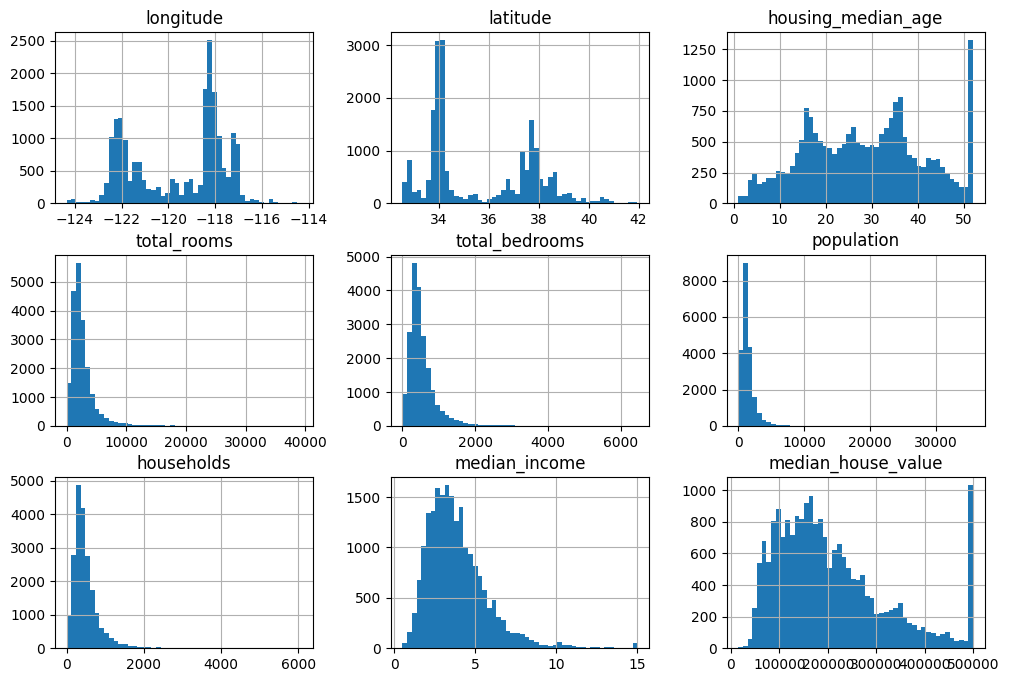

In [12]:
import matplotlib.pyplot as plt


housing.hist(bins=50, figsize=(12,8))

In [18]:
# lets create a test set
# pick some instances randomly, typically 20% of the dataset
# set that data aside

import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)

len(train_set)

16512

In [19]:
len(test_set)

4128

We need to set the random seed to ensure the notebooks output remain the same

In [20]:
np.random.seed(42)

In [21]:
# a possible test set implementation
# computes a hash of each instance's identifier and puts it in the test set
# if the hash is lower than or equal to 20% of the maximum hash value
# ensures that the test set will remain consistent across multiple runs

from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")


In [22]:
# using the row index as a unique identifier
# need to make sure the data is appended to the end of the dataset
# no row is ever deleted

# here is an attempt is build a unique identifier
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [23]:
# SciKit-Learn provides some functions as well to split datasets
# train_test_split() does what we defined above in the split_data_with_id_hash
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


In [24]:
test_set["total_bedrooms"].isnull().sum()

44

To find the probability that a random sample of 1000 contains less than 48.5% or more than 53.5% female when the female population ratio is 51.1%

We can use binomial distrubition from scipy, and using the cdf() method of the binomial distribution will give us the probability that the female % will be greater or less than the given value

In [25]:
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929925


Dividing the median income into homogenous subgroups called strata

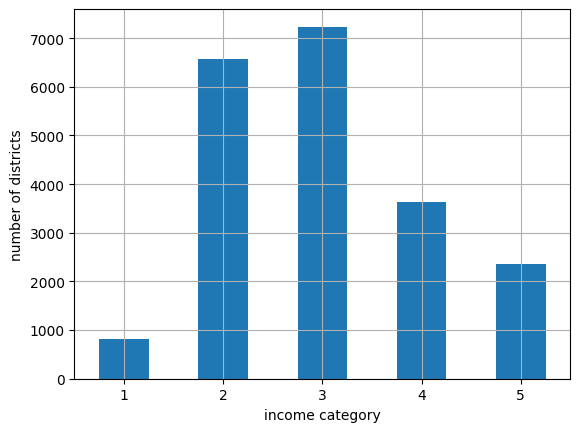

In [26]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0.,1.5,3.0,4.5,6.,np.inf],
                              labels=[1,2,3,4,5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid=True)
plt.xlabel("income category")
plt.ylabel("number of districts")
plt.show()

Having multiple split methods can be useful to better estimate the performance of a model
The following code will generate 10 different stratified splits of the same dataset

stratified sample - this is created to eliminate the risk of introducing significant sampling bias.

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
    
strat_train_set, strat_test_set = strat_splits[0]

A simpler and shorter way

In [28]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"],
                                                   random_state=42)

Lets find the proportion or percentage of each value relative to the entire dataset
This is done by dividing the frequency count of each unique value in the income_category
by the total number of rows in the entire dataset

In [29]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [30]:
# Extra code to compute a figure

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props_index_name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)

(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [31]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    

# Data Exploration

We are now going to explore the data, something we want to do is create a copy of the original so we can revert back after making various transformations

## Visualizing Geographical Data

<function matplotlib.pyplot.show(close=None, block=None)>

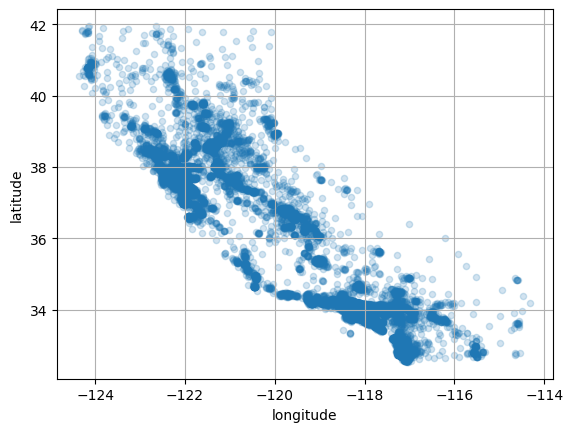

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show

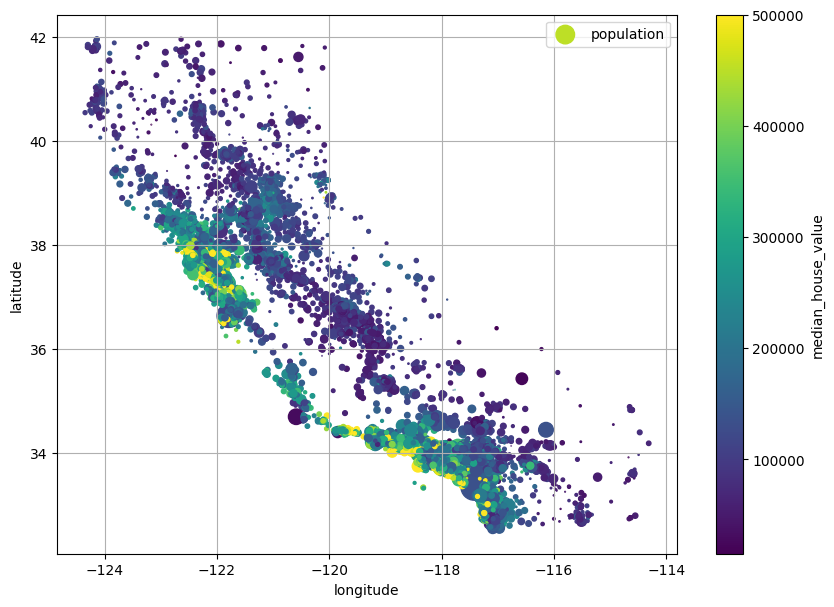

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

plt.show()

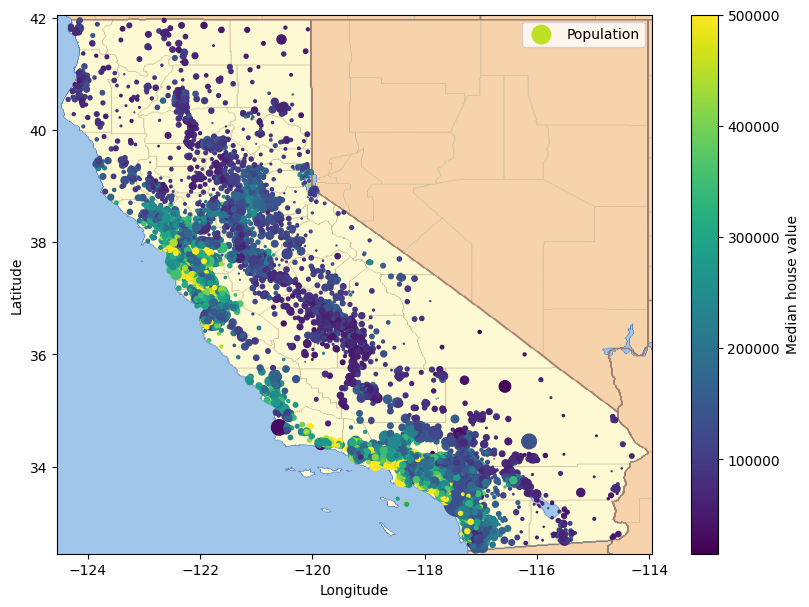

In [34]:
filename = "california.png"

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value",
})

housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(filename)

axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

We can calculate the standard correlation coefficient

In [35]:
corr_matrix = housing.corr(numeric_only = True)

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Correlation coefficient ranges from -1 to 1
when close to 1 it means that there is a strong positive correlation, median house value tends to go up when median income goes up

When the correlation is closer to -1 there is a strong negative correlation, there is a strong negative correlation between median house value and latitude

close to 0 means no linear correlation

Another way to check is using Pandas scatter matrix

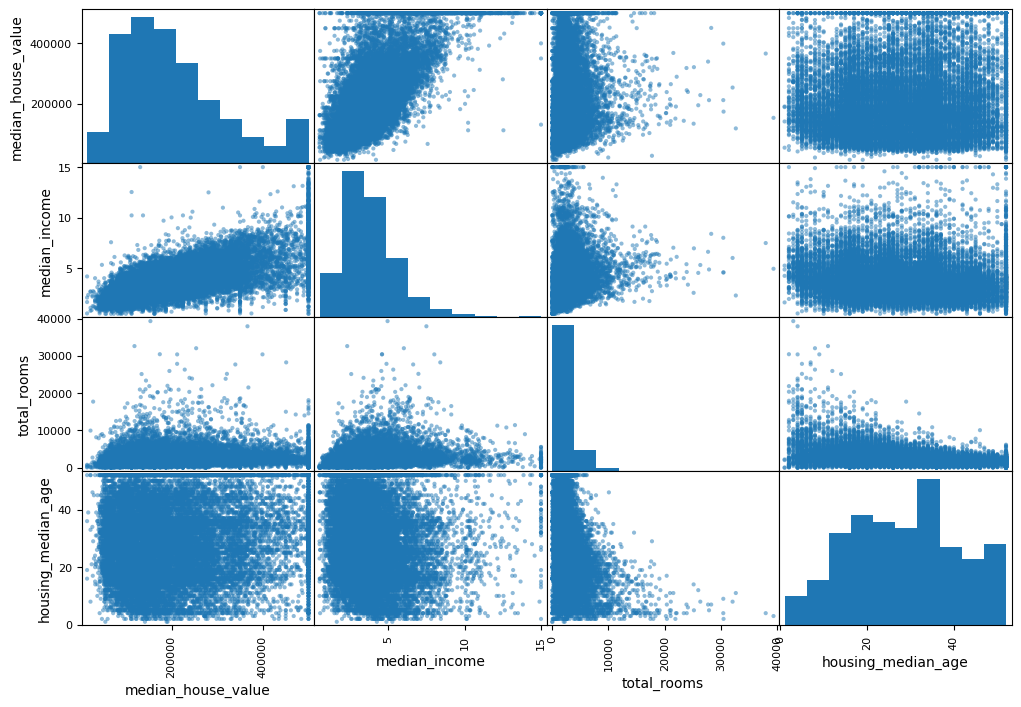

In [36]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

# it looks like there is strong linear correlation between median house value and median income

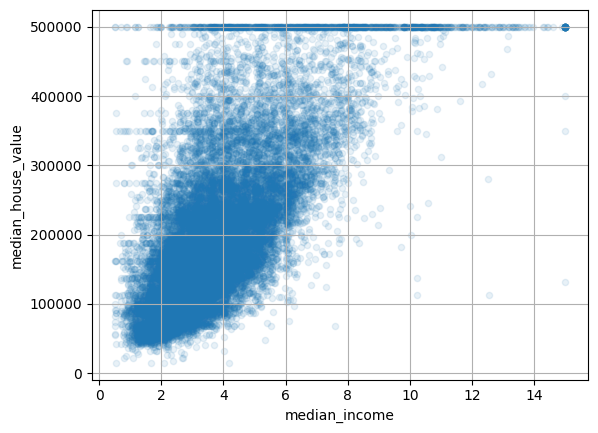

In [37]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

In [38]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedroom_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedroom_ratio        -0.255880
Name: median_house_value, dtype: float64

separate the predictors and labels, as well as revert to a clean training data set (by copying strat_tran_set)

In [174]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy() # in series

pandas.core.series.Series

## Cleaning the data

we noticed total_bedrooms is missing some values, so we could

1. get rid of corresponding districts
2. get rid of the entire attribute
3. set missing values to some value ( this is called imputation )

In [40]:
from sklearn.impute import SimpleImputer
from sklearn import set_config

 # set_config(transform_output = "pandas") allows for transformation input and output to be a pandas dataframe :D
imputer = SimpleImputer(strategy="median")

# we need to exclude ocean proximity as the median can only be computed using numerical values

housing_num = housing.select_dtypes(include=[np.number])

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [41]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [42]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [43]:
x = imputer.transform(housing_num)



In [44]:
# scikit learn transforms outputs into a NumPy array, we can wrap X in a dataframe though simply as follows

housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

## Handling Text and Categorical Attributes

In [45]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


there are a limited number of values, each which represent a category.
lets convert the categories from text to numbers

In [46]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [47]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

An issue that arises is ML algorithms will assume that two nearby values are more similar than two distant values
one way to fix this
one-hot encoding - creating one binary attribute per category (0 and 1)

In [48]:
housing_cat.to_numpy()

array([['NEAR BAY'],
       ['<1H OCEAN'],
       ['INLAND'],
       ...,
       ['NEAR OCEAN'],
       ['<1H OCEAN'],
       ['NEAR OCEAN']], dtype=object)

In [50]:

# OneHotEncoder only takes in a dense matrix, spare matrix is not supported

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

newthing = housing_cat_1hot

In [51]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [52]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


the advantage of OneHotEncoder here is that it remembers which categories it was trained on

In [56]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

The difference is get_dummies only saw two columns
whereas OneHotEncoder output one column per learned category

In [57]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


OneHotEncoder is smarter, it will detect the unknown category and raise an exception
You can set the handle_unknown hyperparamter to ignore in which case it will just represent the unknown category with zeros

In [59]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

When you fit any scitkit-learn estimator using a dataframe, the estimator stoes the column names in the feature_names_in attribute
SciKit-Leanr then enures any df fed to the estimator has the same column names

In [60]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [61]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [62]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                        columns = cat_encoder.get_feature_names_out(),
                        index = df_test_unknown.index)

## Feature Scaling and Transformation

one of the most important transformations for your data
machine learning algorithms do not perform well when the numerical attributes are scaled differently

Two common ways to get all attributes to have the same scale
1. min-max scaling
2. standardization

In [63]:
# this is scikit-learn's transformer MinMaxScaler, this will shift and rescale values so they all range from 0 to 1
# it also has a hyperparameter feature_range that lets you change the range

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

Standardization first subtracts the mean value
then divides the result by the standard deviation
Standardization will not restrict values to a certain range
however it is much less affected by outliers

In [116]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

if a feature distribution has a heavy tale (when values far from the mean are not exponentially rare)
both scaling methods will squash values into a small range

so before scaling the feature you should first transform it to shrink the heavy tail

A common wy to do this for positive features with a heavy tail to the right, is to replace the feature with its square root, replacing the feature with its logarithm may help

### bucketizing

Another way is bucketizing
bucketizing - to chop it distribution into roughly equal-sized buckets and replacing each feature value with the index of the bucket it belongs to

When a feature has a multimodal distribution (with two or more peaks called modes) such as housing_median_age
it can be helpful to bucketize it

another approach to transforming multimodal distributions is to add a feature for each of the modes
representing the similarity between the housing median age and that particular mode.

typically done with radial basis function (RBF) - any function that depends only on the distance between the input value and a fixed point.

In [135]:
# demonstrating the gaussian RBF between housing age x and 35
# given by (-gamma(x-35)**2) gamma here is a hyperparameter that determines how quickly the similarity measure
# decays as x moves away from 35

from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

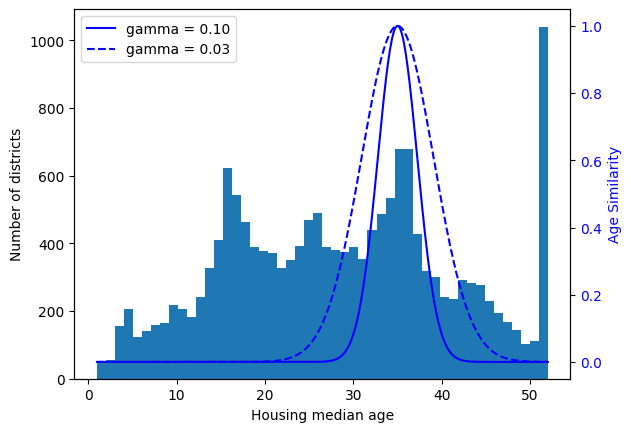

In [152]:
# generating figure 2-18

ages = np.linspace(housing["housing_median_age"].min(),
                    housing["housing_median_age"].max(),
                    500).reshape(-1, 1)

gamma1 = 0.1
gamma2 = 0.03

rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx() # creates a twin x axis
color = "blue"

ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age Similarity", color=color)

plt.legend(loc="upper left")

## The target values may also need to be transformed

if the target distribution has a heavy tail, may need to replace the target with its logarithm,
if you do though the regression model will now predict the log of the median house value, not the real median value
need to compute the exponential of the model's prediction to inverse the logarithm

first we will scale the labels using StandardScaler
then train a simple linear regression model on the resulted scaled labels
inverse_transform from Scikit-Learn will work to compute the inverse on the predictions made by the model


In [176]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame()) # can only take in a 2D input, so series -> dataframe

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

predictions


array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

This works, but we can also use TransformedTargetRegressor
giving it the regression model and label transformer then fitting it on the training set
automatically uses the transformer to scale the labels, train the regression model on the resulting scaled labels,
it will then call the regression models predict() and use inverse_transform to produce the predicton

in short it just does everything I guess


In [179]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformer

need to write own transformers for trasks such as custom transformations, cleanups, or combining attributes

for transformations not requiring any training we can write a function that,

takes a NumPy array as input and outputs the transformed array,
remember its a good idea to transform features with heavy-tails distributions by replacing them with their log

lets create a transformation and apply it to the population feature

In [183]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

example of how to add a feature that will measure geographic similarity between each district and SF

In [200]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

### Useful for combining features aswell

computes the ratio between the input features 0 and 1

In [202]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1.,2.],[3.,4.]]))

array([[0.5 ],
       [0.75]])

## FunctionTransformer() is handy

but what if we want our transformer to be trainable
learning some parameters in the fit() method and using them later in transform()

for this we can write a custom class

this custom transformer acts much like StandardScaler

In [206]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no args or kwargs!
        self.with_mean = with_mean
        
    def fit(self, X, y=None): # y is required even though its not used
        X = check_array(X) # checks X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self # always return self
    
    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes with trailing _
        X = check_arry(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
            return X / self.scale_

## notes

sklearn.utils.validations contains functions that we use to validate the inputs
these are skipped but production code should have them

scikit-learn pipelines require fit() to have X and y, which is why y=None, because we don't use it

All Scikit-Learn estimators set n_featurs_in_ in the fit() method and ensure that the data passed to transform or predict has that number of features

fit() must return self


### KMeans cluster in fit() method

KMeans - groups data points on their similarity or closeness to one another, clustering method of vector quantization

the following code demonstrates a custom transformer that uses a KMeans cluster in the fit() method to identify
the main clusters in the training data, then uses rbf_kernel() in the transform() method to measure how similar each sample is to the cluster center

In [209]:
from sklearn.cluster import KMeans

# ClusterSimilarity inherits BaseEstimate and TransformerMixin
# this is done to allow the class to be used as an estimator and provide necessary methods to transform data

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    # fit method is used to train the clustering algorithm on the input data X
    # creates an instance of KMeans with n clusters and a random state
    # then fits the algorithm to the data
    # fitted KMeans instance is stored in self.kmeans_ and returns self to enable method chaining
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight = sample_weight)
        return self # always return self
    
    # transform is used to transform the input data X into a similarity representation using RBF
    # RBF kernel is calculated between X and the cluster centers obtained from KMeans
    # self.kmeans.cluster_centers_ controls the width of the RBF kernel
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    # returns a list of feature names for transformed data
    
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

## Using the custom transformer

In [211]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                          sample_weight=housing_labels)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [213]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

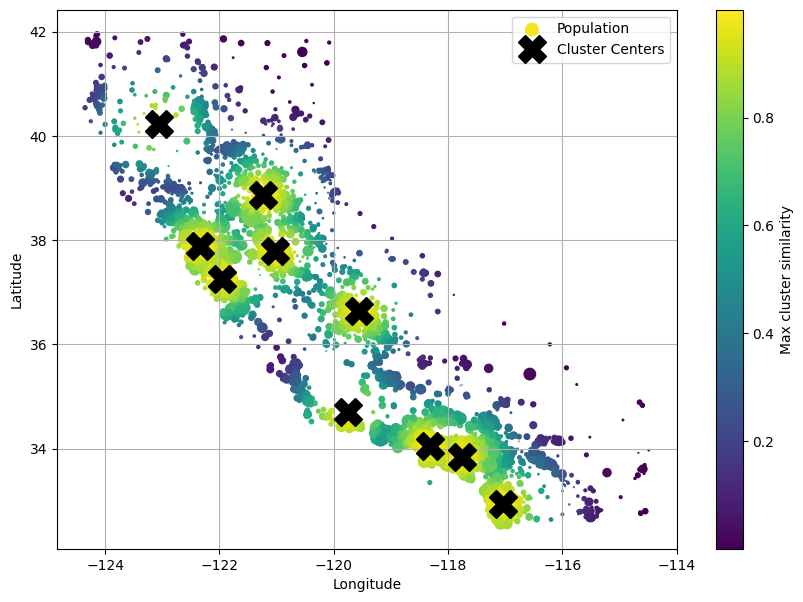

In [228]:
# this code generates the figure 2-19

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median House Value"})

housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
        label="Cluster Centers")

plt.legend(loc="upper right")
plt.show()


This figure shows the 10 cluster centers found by k-means , districts are colored according to their geographic similarity to their closest cluster center.

most clusters are located in highly populated and expensive areas

# Transformation Pipelines

Scikit-Learn provides the Pipeline class to help with sequences of transformation

next is a small pipeline for numerical attributes which will first impute then scale the input features

<span style="color:blue">impute - the process of replacing missing data with substituted values </span>

In [237]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

this will render all Scikit-Learn estimators as interactive diagrams

In [264]:
import sklearn

sklearn.set_config(display="diagram")

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [265]:
# if you dont want to name the transformer use make_pipeline()

from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [243]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [249]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
                                      index=housing_num.index)

df_housing_num_prepared # we can the data after being ran through the pipeline in a dataframe format

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


We have handeled categorical and numerical columns separately, but it would be more convenient to have a single transformer capable of handling everything.

ColumnTransformer will apply num_pipeline to numerical and cat_pipeline to the categorical

In [266]:
from sklearn.compose import ColumnTransformer

num_attributes = ["longitude", "latitude", "housing_median_age", "total_rooms",
                  "total_bedrooms", "population", "households", "median_income"]

cat_attributes = ["ocean_proximity"]

# simple pipeline for categorical is made
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

# columnTransformer constructor requires a list of 3 tuples
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes),
])
    
cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

Since listing all the column names is not convenient, Scikit-Learn provides a make_column_selector() function
which returns a selector function you can use to automatically select all the features of a given type

the following code will do the same thing as before except the pipelines will be automatically named
1. pipeline-1
2. pipeline-2

In [254]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)



Now we are ready to apply this ColumnTransformer to the housing data

In [263]:
housing_prepared = preprocessing.fit_transform(housing)

df_housing_prepared = pd.DataFrame(
    housing_prepared, columns=preprocessing.get_feature_names_out(),
    index=housing.index)

df_housing_prepared.head(8)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0
1286,-0.868193,1.088610,1.861119,-0.370856,-0.561571,-0.668194,-0.472739,-0.276883,0.0,1.0,0.0,0.0,0.0
18078,0.606392,-0.838047,0.430885,-0.710868,-0.808122,-0.837181,-0.893265,1.185526,1.0,0.0,0.0,0.0,0.0
4396,-1.278077,0.830784,0.589800,0.982782,0.858470,0.560383,1.018690,0.811824,0.0,0.0,0.0,1.0,0.0


## recap and creation of single pipeline

Missing values in numerial features will be imputed by replacing them with the median

the categorical feature will be one-hot encoded, most ML algorithms only accept numerical inputs

a few ratio features will be computed and added: bedrooms_ratio, rooms_per_house, people_per_house
this will help correlate with the median house value

a few cluster similarity features will be added

features with a long tail will be replaced by their logarithms, most models prefer a uniform or gaussian distribution

all numerical features will be standardized, most ML algorithms prefer all features to be on the same scale

In [269]:

# takes a two dimensional NumPy array and calculates the calculates the column-wise ratio between the first and second columns
# X[:, [0]] selects all rows from X and the first column [0]
# this creates a column vector with all the values from the first column of X

def column_ratio(X):
    return X[:, [0]] / X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

def ratio_pipeline():
    return make_pipeline (
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) # one column remaining housing_median_age




In [273]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

In [275]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Evaluate and train a model!

FINALLY

In [277]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x288...
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x288585b90>)])),
                ('linearregression', LinearRegression())])

In [283]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([244000., 372400., 128000.,  94300., 329600.])

In [285]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [287]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)

lin_rmse

68689.56594398216

In [289]:
# not good above lets try a DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x288...
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x288585b90>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Model is trained, evaluate on the training set

In [292]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                               squared=False)

tree_rmse

0.0

It is very likely the model has badly overfit the data

One way we can evaluate the decision tree model is train_test_split function to split the training set into a smaller
training set and a validation set

then we can train the models against the smaller training set and evaluate them against the validation set

# k_-fold cross-validation

splits the training set into 10 nonoverlapping subsets called folds,
it then evaluates the decision tree model 10 times
picking a different fold for evaluation every time and using the other 9 folds for training
resulting in 10 eval scores
